In [1]:
import rtde_control
import rtde_receive
import numpy as np
import sys
import cv2
import yaml
from matplotlib import pyplot as plt
import time
sys.path.append("../")

%load_ext autoreload
%autoreload 2


In [ ]:

ultrasoud_vid = cv2.VideoCapture('/dev/video8')
ret, frame = ultrasoud_vid.read()		
plt.imshow(frame)

In [4]:
rtde_c = rtde_control.RTDEControlInterface("192.168.1.2")
rtde_r = rtde_receive.RTDEReceiveInterface("192.168.1.2")

In [5]:
import pickle 
# Load previously recorded waypoints
with open('wps.pkl','rb') as f:
    waypoints = pickle.load(f)
with open('wrench_zero.pkl','rb') as f:
    wrench_zero = pickle.load(f)


In [22]:
# Rescale the grid density if needed
n_x = 50
n_y = 50
xmin,xmax = min([w[0] for w in waypoints]),max([w[0] for w in waypoints])
ymin,ymax = min([w[1] for w in waypoints]),max([w[1] for w in waypoints])

mesh = np.meshgrid(np.linspace(xmin,xmax,n_x),np.linspace(ymin,ymax,n_y))

mesh[0] = mesh[0].flatten()
mesh[1] = mesh[1].flatten()
depth = waypoints[0][2]
orientation = waypoints[0][3:]
waypoints = [[mesh[0][i],mesh[1][i],depth]+orientation  for i in range(len(mesh[0]))]

In [23]:

rtde_c.moveL(waypoints[0], speed = 0.03,acceleration = 0.1)

True

# Data size chart
10x10 grid: 162 MB

25x25 grid: 1.0 GB

50x50 grid: 4.0 GB. Could cause the ipykernel to crash on a 8GB RAM laptop if attempt to store all the data in memory.

In [24]:
save_every = n_x

frames = []
zforces = []
wrenches = []
wp = []
for i,w in enumerate(waypoints):
    rtde_c.moveL(w, speed = 0.01,acceleration = 0.1)
    
    # time.sleep(0.5) # Stabilizing.

    ret,frame = ultrasoud_vid.read()
    frames.append(frame)
    
    wrench= np.array(rtde_r.getActualTCPForce())-np.array(wrench_zero)
    
    wrenches.append(wrench)
    zforces.append(wrench[2])
    wp.append(w)

    print('waypoint',i,'force z',wrench[2])
    if i%save_every == save_every-1 or i==len(waypoints)-1:
        with open('./data/linear_scan_dense_{}.pkl'.format(i//save_every),'wb') as f:
            pickle.dump({'waypoints':wp,'frames':frames, 'zforces':zforces, 'wrenches':wrenches},f)
        
        frames = []
        zforces = []
        wrenches = []
        wp = []

waypoint 0 force z 21.61753335766954
waypoint 1 force z 21.21733795757737
waypoint 2 force z 20.680402175640893
waypoint 3 force z 20.585676746152814
waypoint 4 force z 20.248109440008893
waypoint 5 force z 20.097790860963794
waypoint 6 force z 19.78975002062738
waypoint 7 force z 19.350892834432813
waypoint 8 force z 19.107023739505497
waypoint 9 force z 18.946642488574987
waypoint 10 force z 17.672502446254008
waypoint 11 force z 18.397810286498633
waypoint 12 force z 17.98171675885902
waypoint 13 force z 17.98424732589785
waypoint 14 force z 17.87795198850775
waypoint 15 force z 17.618788140860723
waypoint 16 force z 17.44487189097024
waypoint 17 force z 15.880083206804033
waypoint 18 force z 16.937399445019828
waypoint 19 force z 16.77563185429937
waypoint 20 force z 16.610102444933545
waypoint 21 force z 16.45921283418553
waypoint 22 force z 16.423768604339728
waypoint 23 force z 16.257202411802005
waypoint 24 force z 16.131743742206986
waypoint 25 force z 15.045822283452713
waypo

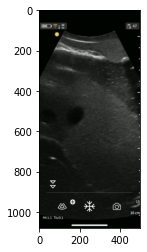

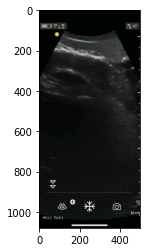

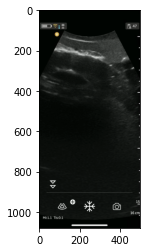

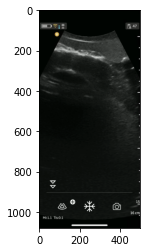

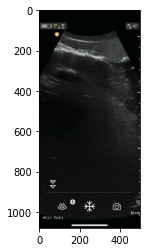

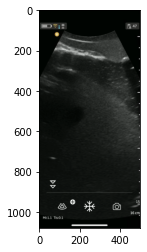

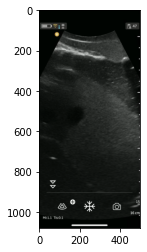

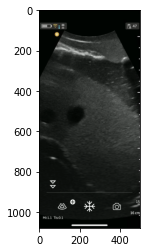

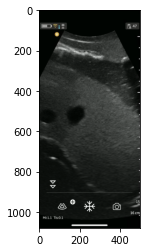

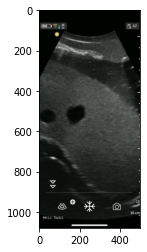

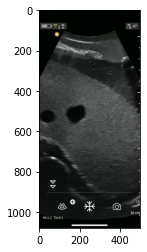

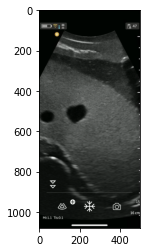

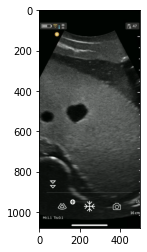

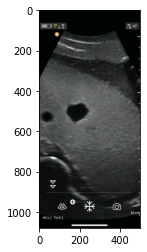

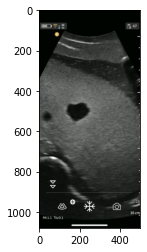

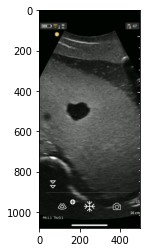

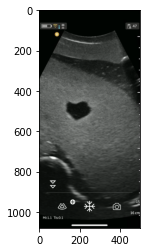

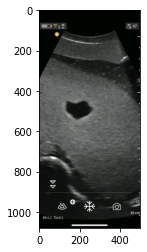

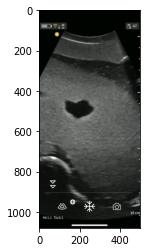

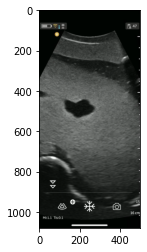

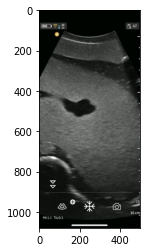

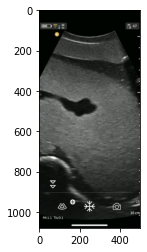

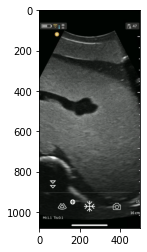

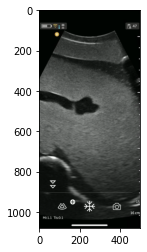

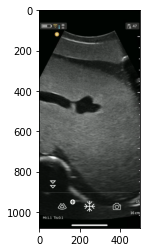

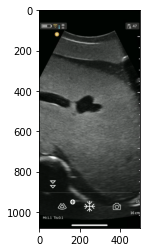

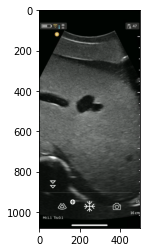

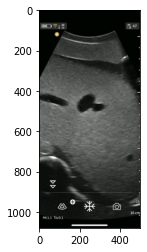

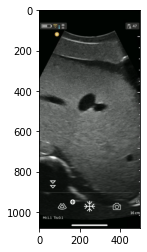

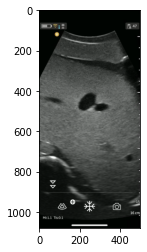

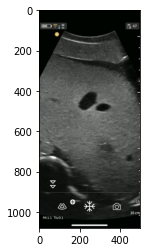

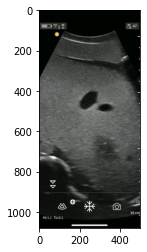

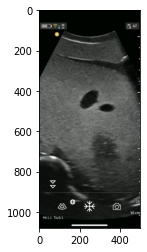

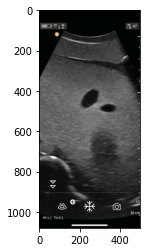

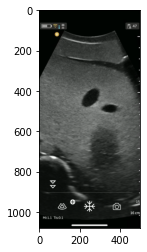

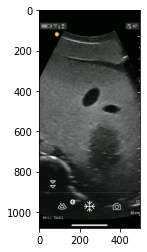

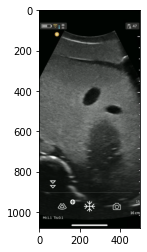

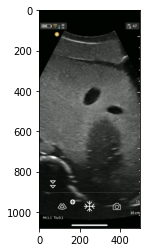

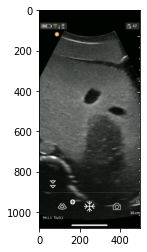

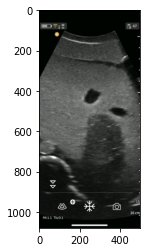

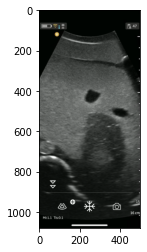

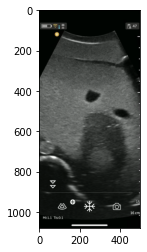

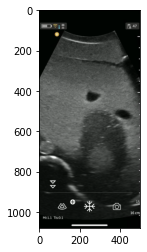

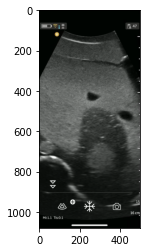

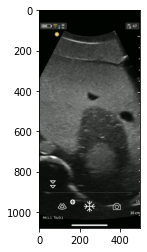

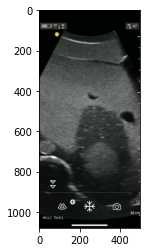

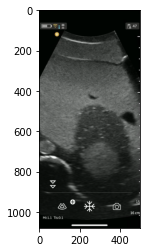

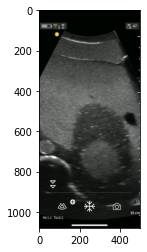

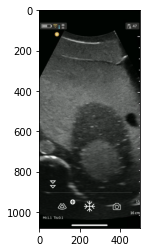

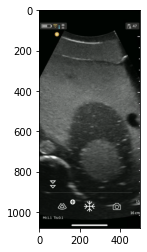

In [27]:
i=25
with open("./data/linear_scan_dense_{}.pkl".format(i),'rb') as f:
    data = pickle.load(f)
    frames = data['frames']
    for f in frames:
        plt.imshow(f)
        plt.show()

In [26]:
ultrasoud_vid.release()